In [98]:
# optimizer with scaling and lin reg

import pandas as pd
import warnings
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
from sklearn.neural_network import MLPRegressor


In [99]:
# CSV Datei lesen und bereinigen
df = pd.read_csv('allRunsAllFractions.csv')

dfTerranReg = df[df["fraction"] == "Terraner"]

# ungültige Spiele aussortieren
dfTerranReg = dfTerranReg[dfTerranReg["supply"] > 0]

# Lategame Spiele mit großer Streuung aussortieren
dfTerranReg = dfTerranReg[dfTerranReg["time"] < 750]

len(dfTerranReg)


2496

In [100]:

df2 = dfTerranReg.sample(frac=0.2)

len(df2)


499

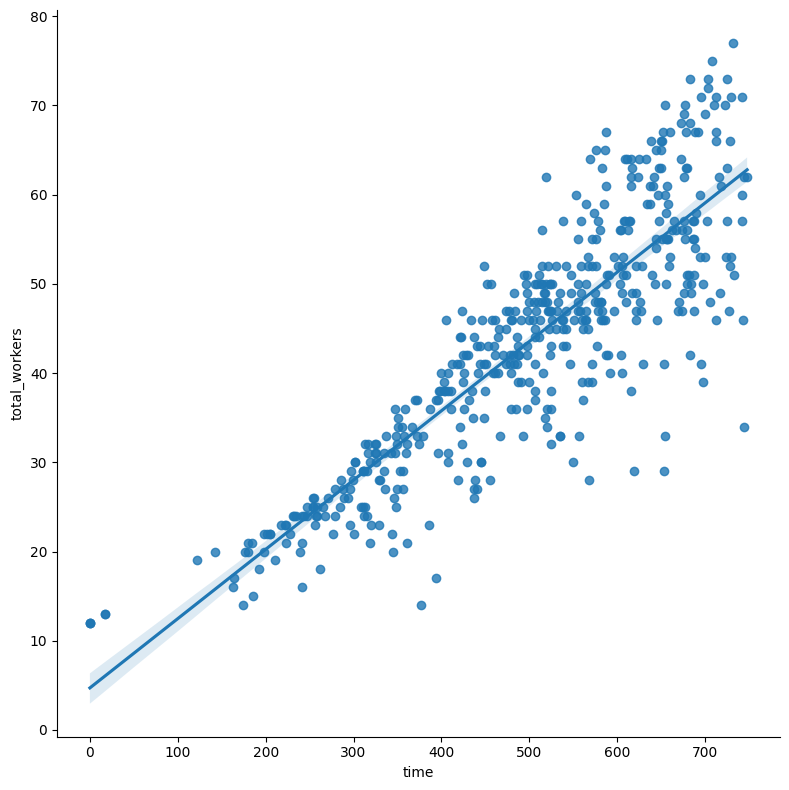

In [101]:

g3= sns.lmplot(x="time", y="total_workers", order=1, data=df2,
          height=8)

In [102]:



X = df2[["total_workers"]]
y = df2["resource_mining"]

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

scaler = StandardScaler()
lin_reg = make_pipeline(scaler, LinearRegression())
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
print(f"The R^2 value in the test set is {r2_score(y_test, y_pred)}")


The R^2 value in the test set is 0.7259599601780354


In [103]:



# ,player,total_workers,total_army_value,total_army,fraction,winner,replay_filename
dfTerran = df2.drop(columns=[
                               "total_workers", "player", "replay_filename", "winner", "fraction", "Unnamed: 0", "total_army_value", "time", "total_army", "supply"])



# create variables
# create Model

m = gp.Model("Worker optimizer")
gppd.set_interactive()

w = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_workers", vtype=gp.GRB.INTEGER)
r_ges = gppd.add_vars(m, pandas_obj=dfTerran,
                      name="resource_mining")
a = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_army", vtype=gp.GRB.INTEGER)

m.update()
dfTerran = dfTerran.drop(columns=["resource_mining"])
dfTerran


""
12345
1542
6024
7103
3294
...
3134
6677
9281
8883


In [104]:

feats = dfTerran
feats = pd.concat([w, feats], axis=1)
feats


,total_workers
12345,<gurobi.Var total_workers[12345]>
1542,<gurobi.Var total_workers[1542]>
6024,<gurobi.Var total_workers[6024]>
7103,<gurobi.Var total_workers[7103]>
3294,<gurobi.Var total_workers[3294]>
...,...
3134,<gurobi.Var total_workers[3134]>
6677,<gurobi.Var total_workers[6677]>
9281,<gurobi.Var total_workers[9281]>
8883,<gurobi.Var total_workers[8883]>


In [105]:


m.setObjective(a.sum(), gp.GRB.MAXIMIZE) # Zielfunktion
gppd.add_constrs(m, ((r_ges - 50*w)/100), gp.GRB.GREATER_EQUAL, a) # Gleichung 2
gppd.add_constrs(m, w + a, gp.GRB.GREATER_EQUAL, 0) # Gleichung 3
gppd.add_constrs(m, w + a, gp.GRB.LESS_EQUAL, 200) # Gleichung 4
m.update()

pred_constr = add_predictor_constr(m, lin_reg, feats, r_ges) # Einfügen des Regressiosmodells
pred_constr.print_stats()
m.optimize()


Model for pipe1:
499 variables
998 constraints
Input has shape (499, 1)
Output has shape (499, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
std_scaler1         (499, 1)          499          499            0            0

lin_reg1            (499, 1)            0          499            0            0

--------------------------------------------------------------------------------
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2495 rows, 1996 columns and 5489 nonzeros
Model fingerprint: 0x7553e78e
Variable types: 998 continuous, 998 integer (0 binary)
Coeffi

In [106]:

outputs = pred_constr.input_values
pred_constr.input_values



,total_workers
12345,55.0
1542,55.0
6024,55.0
7103,55.0
3294,55.0
...,...
3134,55.0
6677,55.0
9281,55.0
8883,55.0
